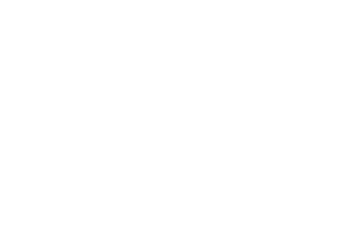

In [212]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, Dense, Reshape, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from tensorflow.keras.models import load_model

# globals
batch_size = 32
plt.axis('off')

# set random state
rs = 42
np.random.seed(42)

In [213]:
x_dim = 464 # 474
y_dim = 12 # 12

In [214]:
# load every image with imgwrite
path = "chromagrams3/"

am = 5287
image_names = os.listdir(path)[:am]

temp, test_files = train_test_split(image_names, train_size=0.85, random_state=rs, shuffle=True)
train_files, val_files = train_test_split(temp, train_size=0.8, random_state=rs, shuffle=True)

In [215]:
# Make this an infinite generator
def gen(img_names):

  while True:

    i = 0
    images = np.zeros((batch_size,y_dim,x_dim), dtype=np.float64)

    while i < len(img_names):
      complete_path = path + img_names[i]
      images[i%batch_size,:,:] = cv2.imread(complete_path, cv2.IMREAD_GRAYSCALE)[:y_dim,:x_dim]/255
      i += 1
      if i%batch_size == 0:
        images = images.reshape(batch_size, y_dim, x_dim, 1)
        yield (images, images)
        images = np.zeros((batch_size,y_dim,x_dim))

In [216]:
train = gen(train_files)
val   = gen(val_files)
test  = gen(test_files)

In [217]:
def imshow(img):
    img = np.fliplr(img.reshape(-1,3)).reshape(img.shape)
    plt.figure(figsize=(30, 10))
    plt.imshow(img, cmap='gray')
    print(img.shape)
    plt.xticks([]), plt.yticks([]) # optional line of code, just to hide tick values on X and Y axis if needed
    plt.show()

In [218]:
xin = Input(shape=(y_dim,x_dim,1))
x = Conv2D(1, (7, 19), activation='relu', padding='same', strides=(1,2))(xin)
x = Conv2D(1, (7, 19), activation='relu', padding='same', strides=(1,2))(x)
x = Reshape((12*116*1,))(x)
encoded = Dense(600)(x)

decoder_in = Input(shape=(600,))
y = Dense(12*116*1)(decoder_in)
y = Reshape((12,116,1))(y)
y = UpSampling2D((1, 2))(y)
y = Conv2D(1, (7, 19), padding='same', activation='relu')(y)
y = UpSampling2D((1, 2))(y)
decoded = Conv2D(1, (7, 19), padding='same', activation='sigmoid')(y)

encoder = Model(xin, encoded)
decoder = Model(decoder_in, decoded)

auto_input = Input(shape=(y_dim,x_dim,1))
encoded = encoder(auto_input)
decoded = decoder(encoded)

model = Model(auto_input, decoded)


model.compile(optimizer='adam', loss='MeanSquaredError') # 'binary_crossentropy'

checkpoint_filepath = '/kaggle/working/Checkpoint/'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    save_best_only=True)

In [219]:
model   = load_model("saves/saves_35_00217/model")
encoder = load_model("saves/saves_35_00217/encoder")
decoder = load_model("saves/saves_35_00217/decoder")

1/1 [==============================] - 0s 258ms/step
(12, 464, 1)


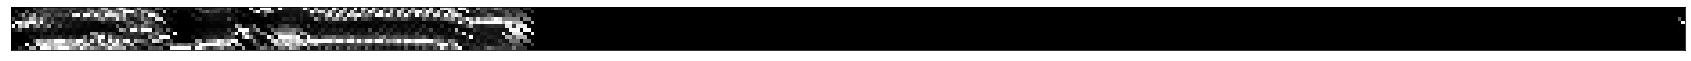

(12, 464, 1)


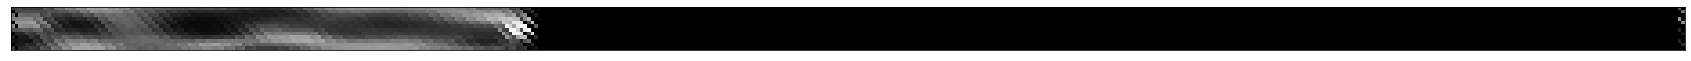

(12, 464, 1)


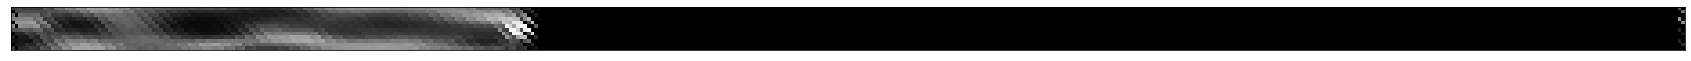

362.92104605116424
0.023152690597097885
0.0
0.0


In [220]:
test_batch = next(test)[0]
decoded_imgs = model.predict(test_batch)

img = test_batch[rs%batch_size]
img2 = decoded_imgs[rs%batch_size]

encoded_imgs = encoder.predict(test_batch)
decoded_imgs = decoder.predict(encoded_imgs)
img3 = decoded_imgs[rs%batch_size]

imshow(img)
imshow(img2)
imshow(img3)
print(np.sum(abs(img-img2)))
print(np.sum((img-img2)*(img-img2)/(x_dim*y_dim)))
print(np.sum(abs(img3-img2)))
print(np.sum((img3-img2)*(img3-img2)/(x_dim*y_dim)))

In [221]:
am_test_steps = len(test_files)//batch_size
encoded_imgs = encoder.predict(test, steps=am_test_steps)

print(encoded_imgs.shape)

24/24 [==============================] - 1s 24ms/step
(768, 35)


In [222]:
cluster_number = range(2,20) 

distortions = []
silhouette_scores = []
calinski_harabasz_scores = []
for n in cluster_number:
    print(n, end=' ')
    estimator = KMeans(n_clusters = n, init='k-means++', n_init=10, max_iter=300)
    y = estimator.fit_predict(encoded_imgs)
    distortions.append(estimator.inertia_)
    silhouette_scores.append(silhouette_score(encoded_imgs,y))
    calinski_harabasz_scores.append(calinski_harabasz_score(encoded_imgs,y))
print()

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


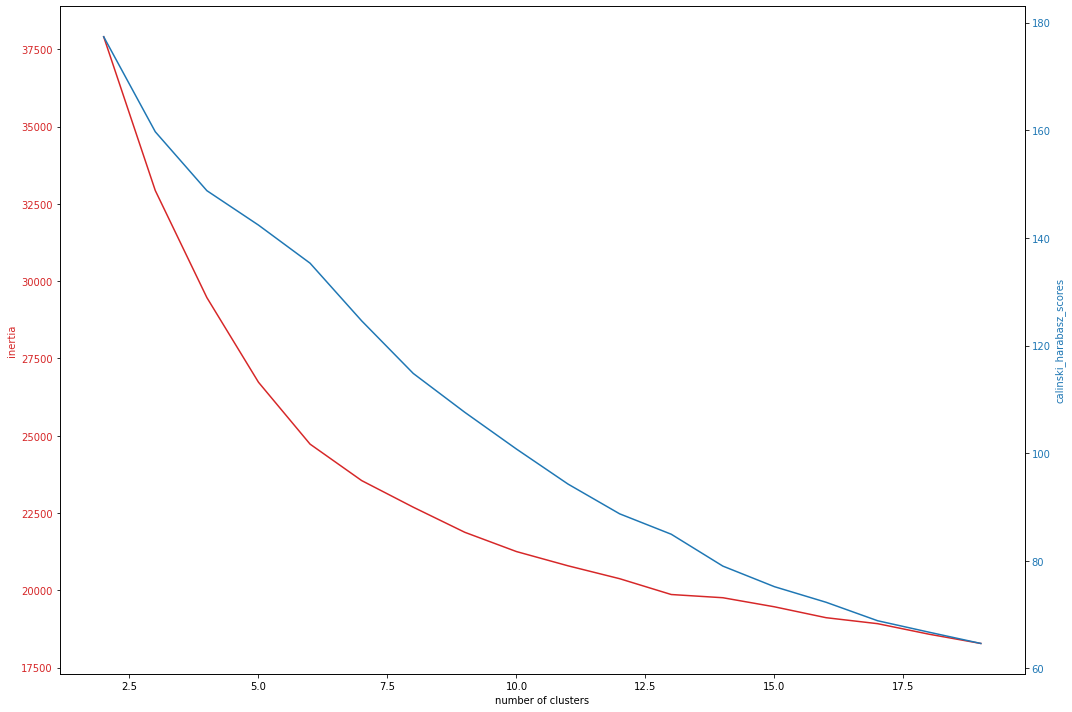

(35,)


In [223]:
t = cluster_number
data1 = distortions
data2 = calinski_harabasz_scores #silhouette_scores

fig, ax1 = plt.subplots(figsize = (15, 10))
          
color = 'tab:red'
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('inertia', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('calinski_harabasz_scores', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim(-0.03,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()
print(encoded_imgs[0].shape)